## Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np
from joblib import dump, load
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import preprocessing as pp

/opt/miniconda3/envs/crystal_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training Functions

In [18]:
def dataset_split(features, labels_r, labels_c train_size=0.7, val_size=0.15):

    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_r_tensor = torch.tensor(labels_r, dtype=torch.float32)
    # labels_c_tensor = torch.tensor(labels_c, dtype=torch.float32)
    

    # Combine features and labels into a custom Dataset

    dataset = TensorDataset(features_tensor, labels_r_tensor)
    

    length = len(dataset)
    train_len = int(length * train_size)
    val_len = int(length * val_size)
    test_len = length - train_len - val_len

    train_data, val_data, test_data = torch.utils.data.random_split(
        dataset, [train_len, val_len, test_len])

    print(train_data)
    return train_data, val_data, test_data


def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


def plot_training_curve(train_loss, val_loss):

    plt.title("Train vs Validation Loss")
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


def train(model, train_data, val_data, batch_size=64, learning_rate=0.01, num_epochs=30, checkpoints=True, plot=True):

    torch.manual_seed(1)

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        val_data, batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    start = time.time()

    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, labels in train_loader:
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        with torch.no_grad():
            model.eval()
            val_loss = 0.0

            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
            val_loss /= len(val_loader)

            val_losses.append(val_loss)

        # scheduler.step(val_loss)

        if checkpoints:
            print(f"_______________________Epoch {epoch + 1}_______________________")

            print("Train loss: {} | Validation loss: {} ".format(
                train_losses[epoch],
                val_losses[epoch]
            ))
            # print("Train acc: {} | Validation acc: {} ".format(
            #     train_accuracies[epoch],
            #     val_accuracies[epoch]
            # ))

    if not checkpoints:
        print(f"_______________________Epoch {num_epochs}_______________________")

        print("Train loss: {} | Validation loss: {} ".format(
            train_losses[num_epochs-1],
            val_losses[num_epochs-1]
        ))
        # print("Train acc: {} | Validation acc: {} ".format(
        #     train_accuracies[num_epochs-1],
        #     val_accuracies[num_epochs-1]
        # ))

    print('Finished Training')
    elapsed_time = time.time() - start
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # make sure to plot the training curves
    if plot:
        plot_training_curve(train_losses, val_losses)
    return train_loss, val_loss

## Architecture

In [3]:
class my_network(nn.Module):
    def __init__(self, sz=[64, 100, 128], inp=54, out=1):
        super(my_network, self).__init__()
        self.layer_sizes = [inp] + sz + [out]
        self.name = "layer4linear"

        self.fc1 = nn.Linear(inp, sz[0])
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(sz[0], sz[1])
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(sz[1], sz[2])
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(sz[2], out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def get_number_params(self):
        num_params = 0
        for i in range(len(self.layer_sizes)-1):
            num_params += self.layer_sizes[i] * \
                self.layer_sizes[i+1] + self.layer_sizes[i+1]
        return num_params

test = my_network()
print(test.get_number_params())

23077


## Loading Data

In [61]:
my_path = '/Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/F225_cubic_key_path'
my_loaded_data = pp.load_data(my_path)

Retrieving: /Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F225_cubic/F225_cubic_features_432.joblib
Retrieving: /Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F225_cubic/F225_cubic_regression_432.joblib
Retrieving: /Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F225_cubic/F225_cubic_labels_classification_space_432.joblib
Retrieving: /Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F225_cubic/F225_cubic_labels_classification_system_432.joblib
Retrieving: /Users/jonathanchoi/Desktop/GitHub Projects/crystal_sim/preprocessed_data/F225_cubic/F225_cubic_material_ids432.joblib


In [62]:
no_angles_regression = []

## Filter through side lengths only
for element in my_loaded_data[1]:
    no_angles_regression.append(element[:1])

train_data, val_data, test_data = dataset_split(
    my_loaded_data[0], no_angles_regression)

### Sanity Check

In [63]:
# for data in my_loaded_data:
#     print(data[:1])

In [64]:

# for i in range(0, 10): #len(my_loaded_data[0])):
#     print(my_loaded_data[2][i])
#     print(my_loaded_data[0][i])
#     my_loaded_data[0][i].append(my_loaded_data[2][i])
#     # print(my_loaded_data[0][i])


In [65]:
# for i in range(0, 10): #len(my_loaded_data[0])):
#     print(my_loaded_data[2][i])
#     print(my_loaded_data[0][i])

## Training

_______________________Epoch 40_______________________
Train loss: 0.7848730691169438 | Validation loss: 1.3934259414672852 
Finished Training
Total time elapsed: 0.43 seconds


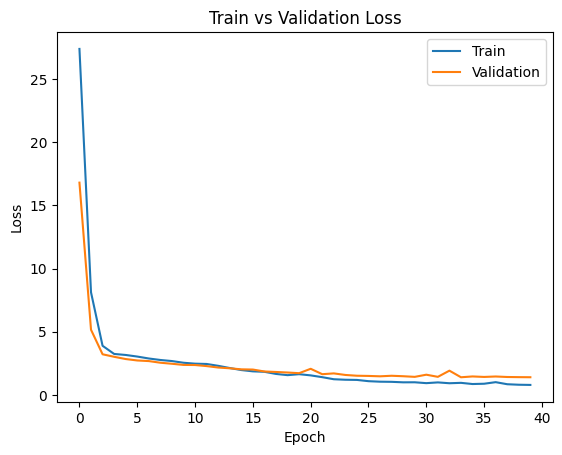

(0.7848730691169438, 1.3934259414672852)

In [70]:
model = my_network()
train(model, train_data, val_data,
      batch_size=16, learning_rate=0.0005, num_epochs=40, checkpoints=False)

In [71]:
model.eval()

test_loss = 0.0
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

gt_list = []
preds_list = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        outputs = model(inputs)
        # print(labels, outputs)
        gt_list.append(labels.tolist())
        preds_list.append(outputs.tolist())

        loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_data)
print(f'Test Loss: {test_loss}')

percent_diffs = []
for i in range(len(gt_list)):
    for j in range(len(gt_list[i])):
        GT = round(gt_list[i][j][0], 2)
        PD = round(preds_list[i][j][0], 2)
        DIFF = round(GT - PD, 2)
        PDIFF = round(abs(GT - PD) / GT * 100, 2)
        percent_diffs.append(PDIFF)

        print(f"GT: {GT:>5.2f}    PD: {PD:>5.2f}    DIFF: {DIFF:>5.2f}    %DIFF: {PDIFF:>5.2f}%")

# Acceptable % difference <= 10%

percent_diffs = np.array(percent_diffs)

print(f"Percentage of inacceptable predictions: {round(len(percent_diffs[percent_diffs > 10])/len(percent_diffs), 2) * 100}%")
print(f"Percentage of acceptable predictions: {round(len(percent_diffs[percent_diffs <= 10])/len(percent_diffs), 2) * 100}%")

Test Loss: 0.028226202523166485
GT:  5.40    PD:  5.29    DIFF:  0.11    %DIFF:  2.04%
GT:  8.28    PD:  8.85    DIFF: -0.57    %DIFF:  6.88%
GT:  5.08    PD:  5.03    DIFF:  0.05    %DIFF:  0.98%
GT:  5.68    PD:  5.53    DIFF:  0.15    %DIFF:  2.64%
GT:  5.68    PD:  5.83    DIFF: -0.15    %DIFF:  2.64%
GT:  9.01    PD:  7.59    DIFF:  1.42    %DIFF: 15.76%
GT:  5.95    PD:  6.20    DIFF: -0.25    %DIFF:  4.20%
GT:  8.41    PD:  6.15    DIFF:  2.26    %DIFF: 26.87%
GT:  4.80    PD:  4.65    DIFF:  0.15    %DIFF:  3.12%
GT:  8.67    PD:  8.31    DIFF:  0.36    %DIFF:  4.15%
GT:  5.13    PD:  5.06    DIFF:  0.07    %DIFF:  1.36%
GT:  5.38    PD:  5.64    DIFF: -0.26    %DIFF:  4.83%
GT:  8.48    PD:  6.60    DIFF:  1.88    %DIFF: 22.17%
GT:  4.28    PD:  4.27    DIFF:  0.01    %DIFF:  0.23%
GT:  5.68    PD:  4.95    DIFF:  0.73    %DIFF: 12.85%
GT:  4.13    PD:  4.19    DIFF: -0.06    %DIFF:  1.45%
GT:  4.65    PD:  4.71    DIFF: -0.06    %DIFF:  1.29%
GT:  7.96    PD:  7.48    DIFF:  

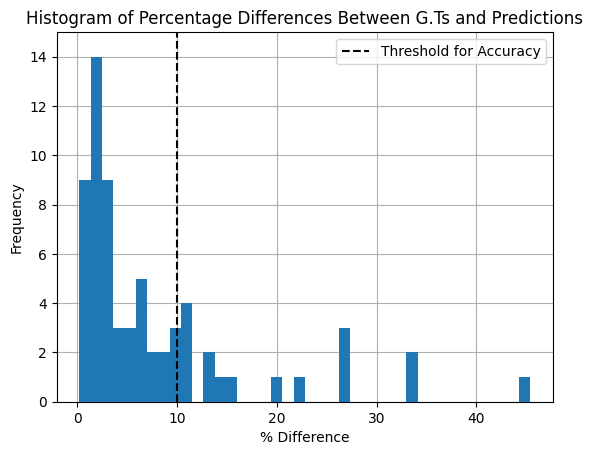

In [76]:
plt.title("Histogram of Percentage Differences Between G.Ts and Predictions")
plt.grid(zorder=0)
plt.hist(percent_diffs, bins=40, zorder=5)
plt.ylim([0,15])
plt.vlines(x=10, ymin = 0, ymax = 30, color='k', linestyles='--', zorder=6, label="Threshold for Accuracy")
plt.xlabel("% Difference")
plt.ylabel("Frequency")
plt.legend(loc="best")